In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import plot_model
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import clear_output, display, Math


In [2]:
from keras.datasets import fashion_mnist


# Про dataset `fassion-mnist`

Fashion-MNIST — це набір зображень статей Zalando, що складається з навчального набору з 60 000 прикладів і тестового набору з 10 000 прикладів. Кожен приклад являє собою зображення в градаціях сірого 28x28, пов'язане з міткою з 10 класів:

| Мітка | Опис        | Переклад         |
|-------|-------------|------------------|
| 0     | T-shirt/top | Футболка/сорочка |
| 1     | Trouser     | Штани            |
| 2     | Pullover    | Светр            |
| 3     | Dress       | Плаття           |
| 4     | Coat        | Пальто           |
| 5     | Sandal      | Сандалі          |
| 6     | Shirt       | Сорочка          |
| 7     | Sneaker     | Кросовки         |
| 8     | Bag         | Сумка            |
| 9     | Ankle boot  | Чоботи           |

# Константи

In [3]:
class_labels = {0: 'T-shirt/top', 1: 'Trouser', 2: 'Pullover', 3: 'Dress',
                4: 'Coat', 5: 'Sandal', 6: 'Shirt', 7: 'Sneaker', 8: 'Bag', 9: 'Ankle boot'}
input_shape = (28, 28, 1)
num_classes = 10


# Підготовка навчального та тестового наборів

In [4]:
# Завантажуємо датасет і розділимо його на навчальну та тестову вибірки.
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Перетворюємо цілочисельні пікселі на тип float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# Нормалізуємо значення пікселів, щоб значення пікселів знаходилось у проміжку від 0 до 1, розділивши яскравість кожного пікселя на 255.
x_train, x_test = x_train / 255., x_test / 255.


# Огляд даних

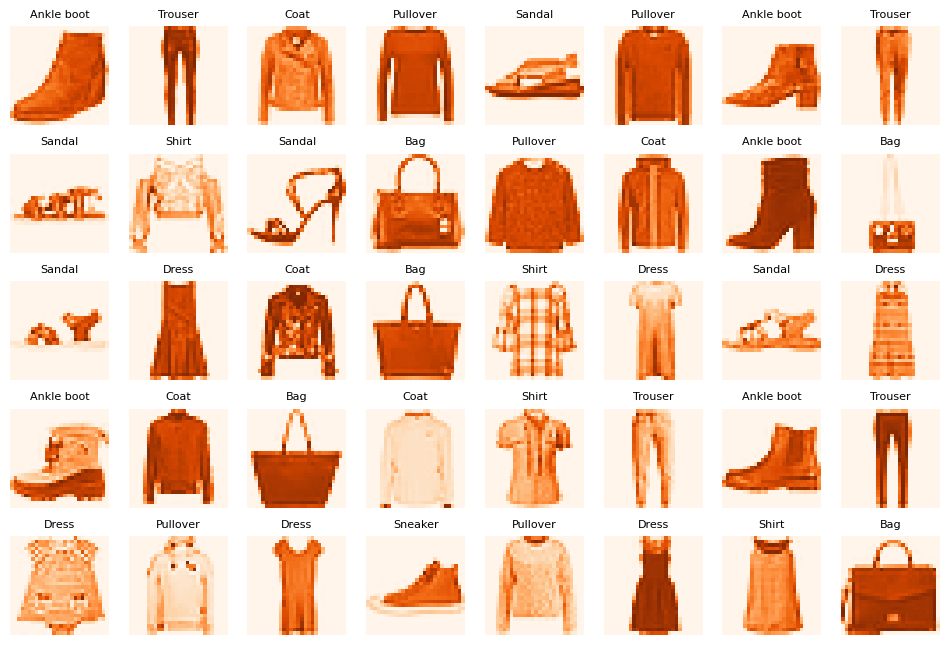

In [26]:
number_of_images = 40
f, ax = plt.subplots(5, 8, figsize=(12, 8))

for i, sample_index in enumerate(np.random.randint(1, x_test.shape[0], number_of_images)):
    test_image = x_test[sample_index].reshape(1, -1)
    test_item = y_test[sample_index]
    ax[i//8, i % 8].imshow(test_image[0].reshape((28, 28)), cmap="Oranges")
    ax[i//8, i % 8].axis('off')
    ax[i//8, i %
        8].set_title(f"{class_labels.get(test_item)}", fontsize=8)
plt.show()


# Побудова Архітектури нейронної мережі (моделі)

In [36]:
# Побудова архітектури моделі
def create_model(dropout_rate):
    model = keras.Sequential()
    model.add(layers.Flatten(input_shape=(28, 28, 1))),
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(dropout_rate)),
    model.add(layers.Dense(64, activation='relu')),
    model.add(layers.Dropout(dropout_rate)),
    model.add(layers.Dense(10, activation='relu')),
    model.add(layers.Dense(10, activation='softmax'))

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model


# Гіперпараметри

In [37]:
epochs = 20
dropout_rate = 0.4
steps_per_epoch = 1_000

model = create_model(dropout_rate)


# Навчання моделі

In [38]:
# Перемішаємо тренувальні дані
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(256).prefetch(1)


# Навчання моделі
history = model.fit(train_data, epochs=epochs,
                    steps_per_epoch=steps_per_epoch, verbose=1)

# Оцінка моделі на тестовому наборі даних
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=1)
print(f'\nТочність на тестовому наборі: {test_accuracy:.2f}')


Epoch 1/20
1000/1000 [==============================] - 8s 6ms/step - loss: 0.6568 - accuracy: 0.7724
Epoch 2/20
1000/1000 [==============================] - 6s 6ms/step - loss: 0.4212 - accuracy: 0.8527
Epoch 3/20
1000/1000 [==============================] - 6s 6ms/step - loss: 0.3816 - accuracy: 0.8649
Epoch 4/20
1000/1000 [==============================] - 6s 6ms/step - loss: 0.3583 - accuracy: 0.8718
Epoch 5/20
 939/1000 [===========================>..] - ETA: 0s - loss: 0.3430 - accuracy: 0.8769

# Характеристики нейронної мережі

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 784)               0         
                                                                 
 dense_9 (Dense)             (None, 128)               100480    
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_10 (Dense)            (None, 64)                8256      
                                                                 
 dense_11 (Dense)            (None, 10)                650       
                                                                 
Total params: 109386 (427.29 KB)
Trainable params: 109386 (427.29 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


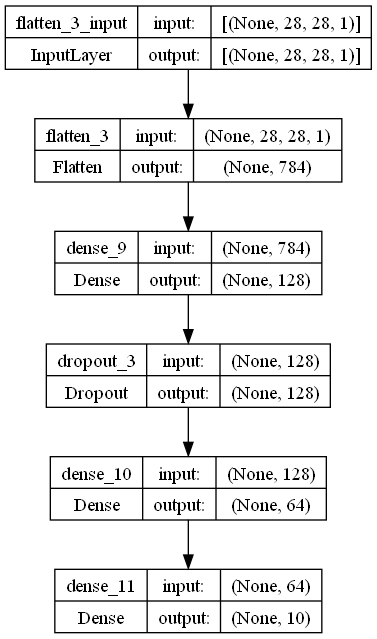

In [29]:
model.summary()
plot_model(model, to_file='model.png', show_shapes=True)
